In [1]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn  # nn 모듈 임포트 추가
import torch.nn.functional as F
from copy import deepcopy

In [2]:
df_ETTh1 = pd.read_csv("./ETTh1.csv")

In [3]:
df_ETTh1.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [4]:
df_ETTh1.shape

(17420, 8)

In [5]:
# 데이터셋 정의 및 처리

class ETTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset="ETTh1", mode="train", scale=True, seq_len=336, pred_len=96):
        super().__init__()
        file_path = f"./{dataset}.csv"  # 현재 디렉토리에 파일 이름 그대로 사용
        df = pd.read_csv(file_path)
        x_y = df.iloc[:,1:]
        time_stamp = df.iloc[:,0]

        assert mode in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[mode]

        self.seq_len = seq_len
        self.pred_len = pred_len

        # 시퀀스 경계 설정
        border1s = [0, 12 * 30 * 24 - self.seq_len, 12 * 30 * 24 + 4 * 30 * 24 - self.seq_len]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        # 데이터 정규화
        if scale:
            train_x_y = x_y.iloc[border1s[0]: border2s[0]]
            self.ss = StandardScaler()
            self.ss.fit(train_x_y.to_numpy(dtype=np.float32))
            x_y = self.ss.transform(x_y.to_numpy(dtype=np.float32))
        else:
            x_y = x_y.to_numpy(dtype=np.float32)

        time_stamp = time_stamp.to_numpy()

        self.data_x = x_y[border1: border2, :]
        self.data_y = x_y[border1: border2, -1]

        self.data_stamp = time_stamp[border1: border2]

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        return seq_x, seq_y

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.ss.inverse_transform(data)

In [6]:
# 데이터 정규화 실행 및 Positional Encoding (위치 인코딩)

class RevIN(torch.nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False, target_idx=-1):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        self.target_idx = target_idx
        if self.affine:
            self._init_params()

    def forward(self, x, mode):
        if mode == "norm":
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == "denorm":
            x = self._denormalize(x)
        else: raise AssertionError
        return x

    def _init_params(self):
        self.affine_weight = torch.nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = torch.nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev[:, :, self.target_idx]
        if self.subtract_last:
            x = x + self.last[:, :, self.target_idx]
        else:
            x = x + self.mean[:, :, self.target_idx]
        return x


class Transpose(torch.nn.Module):
    def __init__(self, *dims, contiguous=False):
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous:
            return x.transpose(*self.dims).contiguous()
        else:
            return x.transpose(*self.dims)


def positional_encoding(q_len, d_model):
    W_pos = torch.empty((q_len, d_model))
    torch.nn.init.uniform_(W_pos, -0.02, 0.02)
    return torch.nn.Parameter(W_pos, requires_grad=True)

In [7]:
# PatchTST Encorder 레이어 정의

class TSTiEncoder(torch.nn.Module):  #i means channel-independent
    def __init__(self, c_in, patch_num, patch_len, max_seq_len=1024,
                 n_layers=3, d_model=128, n_heads=16, d_k=None, d_v=None,
                 d_ff=256, norm='BatchNorm', attn_dropout=0., dropout=0., store_attn=False,
                 key_padding_mask='auto', padding_var=None, attn_mask=None, res_attention=True, pre_norm=False,
                 verbose=False, **kwargs):
        super().__init__()
        self.patch_num = patch_num
        self.patch_len = patch_len
        # Input encoding
        q_len = patch_num
        self.W_P = torch.nn.Linear(patch_len, d_model)        # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len
        # Positional encoding
        self.W_pos = positional_encoding(q_len, d_model)
        # Residual dropout
        self.dropout = torch.nn.Dropout(dropout)
        # Encoder
        self.encoder = TSTEncoder(q_len, d_model, n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout, dropout=dropout,
                                   pre_norm=pre_norm, res_attention=res_attention, n_layers=n_layers, store_attn=store_attn)

    def forward(self, x):                                              # x: [bs x nvars x patch_len x patch_num]

        n_vars = x.shape[1]
        # Input encoding
        x = x.permute(0,1,3,2)                                                   # x: [bs x nvars x patch_num x patch_len]
        x = self.W_P(x)                                                          # x: [bs x nvars x patch_num x d_model]

        u = torch.reshape(x, (x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))      # u: [bs * nvars x patch_num x d_model]
        u = self.dropout(u + self.W_pos)                                         # u: [bs * nvars x patch_num x d_model]

        # Encoder
        z = self.encoder(u)                                                      # z: [bs * nvars x patch_num x d_model]
        z = torch.reshape(z, (-1,n_vars,z.shape[-2],z.shape[-1]))                # z: [bs x nvars x patch_num x d_model]
        z = z.permute(0,1,3,2)                                                   # z: [bs x nvars x d_model x patch_num]

        return z


# Cell
class TSTEncoder(torch.nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=None,
                        norm='BatchNorm', attn_dropout=0., dropout=0.,
                        res_attention=False, n_layers=1, pre_norm=False, store_attn=False):
        super().__init__()

        self.layers = torch.nn.ModuleList([TSTEncoderLayer(q_len, d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm,
                                                      attn_dropout=attn_dropout, dropout=dropout,
                                                      res_attention=res_attention,
                                                      pre_norm=pre_norm, store_attn=store_attn) for i in range(n_layers)])
        self.res_attention = res_attention

    def forward(self, src, key_padding_mask=None, attn_mask=None):
        output = src
        scores = None
        if self.res_attention:
            for mod in self.layers:
                output, scores = mod(output, prev=scores, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output
        else:
            for mod in self.layers:
                output = mod(output, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output



class TSTEncoderLayer(torch.nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=256, store_attn=False,
                 norm='BatchNorm', attn_dropout=0, dropout=0., bias=True, res_attention=False, pre_norm=False):
        super().__init__()
        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = _MultiheadAttention(d_model, n_heads, d_k, d_v, attn_dropout=attn_dropout, proj_dropout=dropout, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = torch.nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_attn = torch.nn.Sequential(Transpose(1,2), torch.nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_attn = torch.nn.LayerNorm(d_model)

        # Position-wise Feed-Forward
        self.ff = torch.nn.Sequential(torch.nn.Linear(d_model, d_ff, bias=bias),
                                torch.nn.GELU(),
                                torch.nn.Dropout(dropout),
                                torch.nn.Linear(d_ff, d_model, bias=bias))

        # Add & Norm
        self.dropout_ffn = torch.nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_ffn = torch.nn.Sequential(Transpose(1,2), torch.nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_ffn = torch.nn.LayerNorm(d_model)

        self.pre_norm = pre_norm
        self.store_attn = store_attn


    def forward(self, src, prev=None, key_padding_mask=None, attn_mask=None):

        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.norm_attn(src)
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            src2, attn = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        if self.store_attn:
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_attn(src)

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.norm_ffn(src)
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_ffn(src)

        if self.res_attention:
            return src, scores
        else:
            return src


class _MultiheadAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads, d_k=None, d_v=None, res_attention=False, attn_dropout=0., proj_dropout=0., qkv_bias=True, lsa=False):
        super().__init__()
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = torch.nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_K = torch.nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_V = torch.nn.Linear(d_model, d_v * n_heads, bias=qkv_bias)

        # Scaled Dot-Product Attention (multiple heads)
        self.res_attention = res_attention
        self.sdp_attn = _ScaledDotProductAttention(d_model, n_heads, attn_dropout=attn_dropout, res_attention=self.res_attention, lsa=lsa)

        # Poject output
        self.to_out = torch.nn.Sequential(torch.nn.Linear(n_heads * d_v, d_model), torch.nn.Dropout(proj_dropout))

    def forward(self, Q, K=None, V=None, prev=None,
                key_padding_mask=None, attn_mask=None):

        bs = Q.size(0)
        if K is None: K = Q
        if V is None: V = Q

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1,2)       # q_s    : [bs x n_heads x max_q_len x d_k]
        k_s = self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0,2,3,1)     # k_s    : [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1,2)       # v_s    : [bs x n_heads x q_len x d_v]

        # Apply Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            output, attn_weights, attn_scores = self.sdp_attn(q_s, k_s, v_s, prev=prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            output, attn_weights = self.sdp_attn(q_s, k_s, v_s, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        # output: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len], scores: [bs x n_heads x max_q_len x q_len]

        # back to the original inputs dimensions
        output = output.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v) # output: [bs x q_len x n_heads * d_v]
        output = self.to_out(output)

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights


class _ScaledDotProductAttention(torch.nn.Module):
    def __init__(self, d_model, n_heads, attn_dropout=0., res_attention=False, lsa=False):
        super().__init__()
        self.attn_dropout = torch.nn.Dropout(attn_dropout)
        self.res_attention = res_attention
        head_dim = d_model // n_heads
        self.scale = torch.nn.Parameter(torch.tensor(head_dim ** -0.5), requires_grad=lsa)
        self.lsa = lsa

    def forward(self, q, k, v, prev=None, key_padding_mask=None, attn_mask=None):
        # Scaled MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        attn_scores = torch.matmul(q, k) * self.scale      # attn_scores : [bs x n_heads x max_q_len x q_len]

        # Add pre-softmax attention scores from the previous layer (optional)
        if prev is not None: attn_scores = attn_scores + prev

        # Attention mask (optional)
        if attn_mask is not None:                                     # attn_mask with shape [q_len x seq_len] - only used when q_len == seq_len
            if attn_mask.dtype == torch.bool:
                attn_scores.masked_fill_(attn_mask, -np.inf)
            else:
                attn_scores += attn_mask

        # Key padding mask (optional)
        if key_padding_mask is not None:                              # mask with shape [bs x q_len] (only when max_w_len == q_len)
            attn_scores.masked_fill_(key_padding_mask.unsqueeze(1).unsqueeze(2), -np.inf)

        # normalize the attention weights
        attn_weights = torch.nn.functional.softmax(attn_scores, dim=-1)                 # attn_weights   : [bs x n_heads x max_q_len x q_len]
        attn_weights = self.attn_dropout(attn_weights)

        # compute the new values given the attention weights
        output = torch.matmul(attn_weights, v)                        # output: [bs x n_heads x max_q_len x d_v]

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights

In [8]:
# Flatten Head Layer 구현

class Flatten_Head(torch.nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = torch.nn.Flatten(start_dim=-3)
        self.linear = torch.nn.Linear(nf * n_vars, target_window)
        self.dropout = torch.nn.Dropout(head_dropout)

    def forward(self, x):                                 # x: [bs x nvars x d_model x patch_num]
        x = self.flatten(x)                               # x: [bs x nvars * d_model * patch_num]
        x = self.linear(x)                                # x: [bs x target_window]
        x = self.dropout(x)
        return x

In [9]:
# PatchTST 모델 구현

class PatchTST(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window, patch_len, stride, max_seq_len=1024,
                 n_layers=3, d_model=16, n_heads=4, d_k=None, d_v=None,
                 d_ff=128, attn_dropout=0.0, dropout=0.3, key_padding_mask='auto',
                 padding_var=None, attn_mask=None, res_attention=True, pre_norm=False, store_attn=False,
                 head_dropout = 0.0, padding_patch = "end",
                 revin = True, affine = False, subtract_last = False,
                 verbose=False, target_idx=-1, **kwargs):
        super().__init__()

        self.revin = revin
        if revin:
            self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last, target_idx=target_idx)

        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        patch_num = int((context_window - patch_len)/stride + 1)

        if padding_patch == "end":
            self.padding_patch_layer = torch.nn.ReplicationPad1d((0, stride))
            patch_num += 1

        self.backbone = TSTiEncoder(c_in, patch_num=patch_num, patch_len=patch_len, max_seq_len=max_seq_len,
                                n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff,
                                attn_dropout=attn_dropout, dropout=dropout, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                verbose=verbose, **kwargs)

        self.head_nf = d_model * patch_num
        self.n_vars = c_in

        self.head = Flatten_Head(self.n_vars, self.head_nf, target_window, head_dropout=head_dropout)

    def forward(self, z):                                                                   # z: [bs x seq_len × nvars]
        # instance norm
        if self.revin:
            z = self.revin_layer(z, 'norm')
            z = z.permute(0,2,1)                                                            # z: [bs x nvars × seq_len]

        # do patching
        if self.padding_patch == 'end':
            z = self.padding_patch_layer(z)
        z = z.unfold(dimension=-1, size=self.patch_len, step=self.stride)                   # z: [bs x nvars x patch_num x patch_len]
        z = z.permute(0,1,3,2)                                                              # z: [bs x nvars x patch_len x patch_num]

        # model
        z = self.backbone(z)                                                                # z: [bs x nvars x d_model x patch_num]
        z = self.head(z)                                                                    # z: [bs x target_window]

        # denorm
        if self.revin:
            z = self.revin_layer(z, 'denorm')
        return z

In [10]:
def distillation_loss(student_output, teacher_output, true_output, alpha=0.5, temperature=3.0):
    # Flatten student and teacher outputs for KL divergence
    student_output = student_output.view(student_output.size(0), -1)  # [batch_size, num_features * pred_len]
    teacher_output = teacher_output.view(teacher_output.size(0), -1)  # [batch_size, num_features * pred_len]

    # Compute distillation loss
    distill_loss = F.kl_div(
        F.log_softmax(student_output / temperature, dim=1),
        F.softmax(teacher_output / temperature, dim=1),
        reduction="batchmean",
    ) * (temperature ** 2)

    # Compute MSE loss
    true_output = true_output.view(true_output.size(0), -1)  # [batch_size, num_features * pred_len]
    mse_loss = F.mse_loss(student_output, true_output)

    # Combine losses
    return alpha * distill_loss + (1 - alpha) * mse_loss


In [11]:

# 비교를 위한 Linear model 정의

class Linear(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window):
        super().__init__()
        self.c_in = c_in
        self.context_winsoq = context_window
        self.target_window = target_window

        self.flatten = torch.nn.Flatten(start_dim=-2)

        self.linear = torch.nn.Linear(c_in * context_window, target_window)

    def forward(self, x):                   # x: [bs x seq_len × nvars]
        x = self.flatten(x)                 # x: [bs x seq_len * nvars]
        x = self.linear(x)                  # x: [bs x target_window]
        return x


class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(torch.nn.Module):
    def __init__(self, c_in, context_window, target_window):
        super().__init__()
        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.flatten_Seasonal = torch.nn.Flatten(start_dim=-2)
        self.flatten_Trend = torch.nn.Flatten(start_dim=-2)

        self.Linear_Seasonal = torch.nn.Linear(c_in * context_window, target_window)
        self.Linear_Trend = torch.nn.Linear(c_in * context_window, target_window)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init = self.flatten_Seasonal(x)
        trend_init = self.flatten_Trend(x)

        seasonal_output = self.Linear_Seasonal(seasonal_init)
        trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x

In [12]:
# 모델의 학습, 검증, 테스트

class Learner:
    def __init__(self, model, dataset, batch_size=128, lr=0.0001, epochs=100, target_window=96, d_model=16, adjust_lr=True, adjust_factor=0.001):
        self.model = model.to("cuda")
        self.batch_size = batch_size
        train_dataset = dataset(mode="train")
        valid_dataset = dataset(mode="val")
        test_dataset = dataset(mode="test")
        self.train_datalen = len(train_dataset)
        self.valid_datalen = len(valid_dataset)
        self.train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        self.test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        self.lr=lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss()
        self.epochs = epochs
        self.target_window=target_window
        self.best_weight = self.model.state_dict()
        self.d_model=d_model
        self.adjust_lr = adjust_lr
        self.adjust_factor = adjust_factor

    def adjust_learning_rate(self, steps, warmup_step=300, printout=True):
        if steps**(-0.5) < steps * (warmup_step**-1.5):
            lr_adjust = (16**-0.5) * (steps**-0.5) * self.adjust_factor
        else:
            lr_adjust = (16**-0.5) * (steps * (warmup_step**-1.5)) * self.adjust_factor

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr_adjust
        if printout:
            print('Updating learning rate to {}'.format(lr_adjust))
        return

    def train(self):
        best_valid_loss = np.inf
        train_history = []
        valid_history = []
        train_steps = 1
        if self.adjust_lr:
            self.adjust_learning_rate(train_steps)
        for epoch in range(self.epochs):
            #train
            self.model.train()
            iter_count = 0
            total_loss = 0

            for train_x, train_y in self.train_dataloader:
                train_x = train_x.to("cuda")
                train_y = train_y.to("cuda")

                pred_y = self.model(train_x)
                loss = self.loss(pred_y, train_y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                iter_count += 1
                train_steps += 1
            if self.adjust_lr:
                self.adjust_learning_rate(train_steps)

            #valid
            self.model.eval()
            valid_iter_count = 0
            valid_total_loss = 0
            with torch.no_grad():
                for valid_x, valid_y in self.valid_dataloader:
                    valid_x = valid_x.to("cuda")
                    valid_y = valid_y.to("cuda")
                    pred_y = self.model(valid_x)
                    loss = self.loss(pred_y, valid_y)
                    valid_total_loss += loss.item()
                    valid_iter_count += 1

            total_loss /= iter_count
            valid_total_loss /= valid_iter_count
            print("epoch: {} MSE loss: {:.4f} MSE valid loss: {:.4f}".format(epoch, total_loss, valid_total_loss))
            if best_valid_loss >= valid_total_loss:
                self.best_weight = self.model.state_dict()
                best_valid_loss = valid_total_loss
                print("Best score! Weights of the model are updated!")
            train_history.append(total_loss)
            valid_history.append(valid_total_loss)
        return train_history, valid_history

    def test(self):
        self.model.load_state_dict(self.best_weight)
        self.model.eval()
        iter_count = 0
        total_loss = 0
        with torch.no_grad():
            for test_x, test_y in self.test_dataloader:
                test_x = test_x.to("cuda")
                test_y = test_y.to("cuda")
                pred_y = self.model(test_x)
                loss = self.loss(pred_y, test_y)
                total_loss += loss.item()
                iter_count += 1
        total_loss /= iter_count
        print("MSE test loss: {:.4f}".format(total_loss))

In [13]:
class DistillationLearner(Learner):
    def __init__(self, teacher_model, student_model, dataset, alpha=0.5, temperature=3.0, **kwargs):
        # 교사 모델 초기화 및 학습 불가능하게 설정
        self.teacher_model = deepcopy(teacher_model).to("cuda")
        for param in self.teacher_model.parameters():
            param.requires_grad = False  # 교사 모델은 학습되지 않도록 설정

        # 부모 클래스 초기화
        super().__init__(model=student_model, dataset=dataset, **kwargs)

        # 증류 학습에 필요한 파라미터 설정
        self.alpha = alpha
        self.temperature = temperature

    def train(self):
        best_valid_loss = float("inf")
        train_history = []
        valid_history = []
        train_steps = 1

        for epoch in range(self.epochs):
            self.model.train()
            self.teacher_model.eval()
            epoch_loss = 0

            for batch_idx, (train_x, train_y) in enumerate(self.train_dataloader):
                train_x, train_y = train_x.to("cuda"), train_y.to("cuda")

                # 학생 모델 예측
                student_pred = self.model(train_x)

                # 교사 모델 예측
                with torch.no_grad():
                    teacher_pred = self.teacher_model(train_x)

                # 증류 손실 계산
                loss = distillation_loss(student_pred, teacher_pred, train_y, self.alpha, self.temperature)

                # 역전파 및 가중치 업데이트
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

                # 학습률 조정
                if self.adjust_lr:
                    self.adjust_learning_rate(train_steps, printout=False)
                train_steps += 1

            # 학습 손실 기록
            avg_train_loss = epoch_loss / len(self.train_dataloader)

            # 검증 손실 계산
            self.model.eval()
            valid_loss = 0
            with torch.no_grad():
                for valid_x, valid_y in self.valid_dataloader:
                    valid_x, valid_y = valid_x.to("cuda"), valid_y.to("cuda")
                    pred_y = self.model(valid_x)
                    valid_loss += self.loss(pred_y, valid_y).item()
            avg_valid_loss = valid_loss / len(self.valid_dataloader)

            print(f"epoch: {epoch + 1} MSE loss: {avg_train_loss:.4f} MSE valid loss: {avg_valid_loss:.4f}")

            if best_valid_loss >= avg_valid_loss:
                self.best_weight = self.model.state_dict()
                best_valid_loss = avg_valid_loss

            train_history.append(avg_train_loss)
            valid_history.append(avg_valid_loss)

        return train_history, valid_history

    def test(self):
        self.model.load_state_dict(self.best_weight)
        self.model.eval()
        iter_count = 0
        total_loss = 0

        with torch.no_grad():
            for test_x, test_y in self.test_dataloader:
                test_x = test_x.to("cuda")
                test_y = test_y.to("cuda")
                pred_y = self.model(test_x)
                loss = self.loss(pred_y, test_y)
                total_loss += loss.item()
                iter_count += 1

        total_loss /= iter_count
        print(f"MSE test loss: {total_loss:.4f}")
        return total_loss

    def adjust_learning_rate(self, steps, warmup_step=300, printout=False):
        if steps**(-0.5) < steps * (warmup_step**-1.5):
            lr_adjust = (self.d_model**-0.5) * (steps**-0.5) * self.adjust_factor
        else:
            lr_adjust = (self.d_model**-0.5) * (steps * (warmup_step**-1.5)) * self.adjust_factor

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr_adjust
        if printout:
            print(f'Updating learning rate to {lr_adjust}')
        return


In [14]:

c_in = 7
context_window = 336
target_window = 96
patch_len = 16
stride = 8

In [15]:
class StudentModel(nn.Module):
    def __init__(self, num_features, seq_len, pred_len, hidden_dim, patch_len, stride, n_layers=2, d_model=16, n_heads=2, dropout=0.1):
        super(StudentModel, self).__init__()
        self.num_features = num_features
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.hidden_dim = hidden_dim
        self.patch_len = patch_len
        self.stride = stride

        # Patch 계산
        self.patch_num = int((seq_len - patch_len) / stride + 1)

        # 입력 프로젝션: 패치 데이터를 d_model 차원으로 매핑
        self.input_proj = nn.Linear(patch_len * num_features, d_model)

        # Transformer Encoder
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=n_heads,
                dim_feedforward=d_model * 4,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=n_layers
        )

        # 예측 Head
        self.head = nn.Sequential(
            nn.Linear(d_model * self.patch_num, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, pred_len)
        )

    def forward(self, x):
        # x: [batch_size, seq_len, num_features]
        batch_size, seq_len, num_features = x.shape

        # 패치 생성
        x = x.unfold(dimension=1, size=self.patch_len, step=self.stride)  # [batch_size, patch_num, patch_len, num_features]
        x = x.permute(0, 1, 3, 2)  # [batch_size, patch_num, num_features, patch_len]
        x = x.flatten(start_dim=2)  # [batch_size, patch_num, patch_len * num_features]

        # 입력 프로젝션
        x = self.input_proj(x)  # [batch_size, patch_num, d_model]

        # Transformer Encoder
        x = self.encoder(x)  # [batch_size, patch_num, d_model]

        # Flatten 및 예측
        x = x.flatten(start_dim=1)  # [batch_size, patch_num * d_model]
        x = self.head(x)  # [batch_size, pred_len]

        return x


In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
patchtst_model = PatchTST(c_in=c_in, context_window=context_window, target_window=target_window, patch_len=patch_len, stride=stride)

In [18]:
num_features = c_in           # 입력 feature 수
seq_len = context_window       # 입력 시계열 길이
pred_len = target_window       # 예측 시계열 길이
hidden_dim = 128               # 학생 모델 은닉층 크기
patch_len = 16                 # 패치 길이
stride = 8                     # 스트라이드

teacher_model = patchtst_model

student_model = StudentModel(
    num_features=num_features,  # 입력 feature 수
    seq_len=seq_len,            # 입력 시계열 길이
    pred_len=pred_len,          # 예측 시계열 길이
    hidden_dim=hidden_dim,      # 은닉층 크기
    patch_len=patch_len,        # 패치 길이
    stride=stride,              # 스트라이드
    n_layers=2,                 # Transformer 레이어 수
    d_model=16,                 # 모델 차원
    n_heads=2,                  # 헤드 수
    dropout=0.1                 # 드롭아웃 비율
)

In [19]:
Linear_model = Linear(c_in=c_in, context_window=context_window, target_window=target_window)
DLinear_model = DLinear(c_in=c_in, context_window=context_window, target_window=target_window)

In [20]:
Linear_learner = Learner(model=Linear_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.01)
DLinear_learner = Learner(model=DLinear_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.01)
patchtst_learner = Learner(model=patchtst_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.001)
student_learner = Learner(model=student_model, dataset=ETTDataset, adjust_lr=True, adjust_factor=0.01)

In [21]:
Linear_train_history, Linear_valid_history = Linear_learner.train()
DLinear_train_history, DLinear_valid_history = DLinear_learner.train()
patchtst_train_history, patchtst_valid_history = patchtst_learner.train()


Updating learning rate to 4.811252243246882e-07
Updating learning rate to 3.1754264805429416e-05
epoch: 0 MSE loss: 1.1685 MSE valid loss: 0.8118
Best score! Weights of the model are updated!
Updating learning rate to 6.302740438653415e-05
epoch: 1 MSE loss: 0.5663 MSE valid loss: 0.6749
Best score! Weights of the model are updated!
Updating learning rate to 9.430054396763888e-05
epoch: 2 MSE loss: 0.3087 MSE valid loss: 0.5496
Best score! Weights of the model are updated!
Updating learning rate to 0.00012557368354874362
epoch: 3 MSE loss: 0.2410 MSE valid loss: 0.4157
Best score! Weights of the model are updated!
Updating learning rate to 0.00013846219390542782
epoch: 4 MSE loss: 0.2072 MSE valid loss: 0.2954
Best score! Weights of the model are updated!
Updating learning rate to 0.0001264304343560434
epoch: 5 MSE loss: 0.1872 MSE valid loss: 0.2646
Best score! Weights of the model are updated!
Updating learning rate to 0.00011707322644771175
epoch: 6 MSE loss: 0.1755 MSE valid loss: 

In [22]:
distillation_learner = DistillationLearner(
    teacher_model=teacher_model,
    student_model=student_model,
    dataset=ETTDataset,
    batch_size=128,
    lr=0.001,
    epochs=100,
    alpha=0.5,  # 증류 손실 비율 변경
    temperature=2.5  # 로짓 부드러움 조정
)

student_train_history, student_valid_history = distillation_learner.train()


epoch: 1 MSE loss: 0.4557 MSE valid loss: 0.3547
epoch: 2 MSE loss: 0.4432 MSE valid loss: 0.3455
epoch: 3 MSE loss: 0.4177 MSE valid loss: 0.3320
epoch: 4 MSE loss: 0.3740 MSE valid loss: 0.3145
epoch: 5 MSE loss: 0.3188 MSE valid loss: 0.2948
epoch: 6 MSE loss: 0.2536 MSE valid loss: 0.2780
epoch: 7 MSE loss: 0.2053 MSE valid loss: 0.2652
epoch: 8 MSE loss: 0.1707 MSE valid loss: 0.2571
epoch: 9 MSE loss: 0.1451 MSE valid loss: 0.2562
epoch: 10 MSE loss: 0.1290 MSE valid loss: 0.2569
epoch: 11 MSE loss: 0.1182 MSE valid loss: 0.2565
epoch: 12 MSE loss: 0.1103 MSE valid loss: 0.2539
epoch: 13 MSE loss: 0.1054 MSE valid loss: 0.2471
epoch: 14 MSE loss: 0.1017 MSE valid loss: 0.2373
epoch: 15 MSE loss: 0.0983 MSE valid loss: 0.2264
epoch: 16 MSE loss: 0.0956 MSE valid loss: 0.2146
epoch: 17 MSE loss: 0.0940 MSE valid loss: 0.2037
epoch: 18 MSE loss: 0.0922 MSE valid loss: 0.1945
epoch: 19 MSE loss: 0.0902 MSE valid loss: 0.1883
epoch: 20 MSE loss: 0.0887 MSE valid loss: 0.1813
epoch: 21

In [23]:
Linear_learner.test()

MSE test loss: 0.0964


In [24]:
DLinear_learner.test()

MSE test loss: 0.1098


In [25]:
patchtst_learner.test()

MSE test loss: 0.0632


In [26]:
distillation_learner.test()

MSE test loss: 0.3857


0.38571996851400897

In [27]:
distillation_learner.test()

MSE test loss: 0.3857


0.38571996851400897

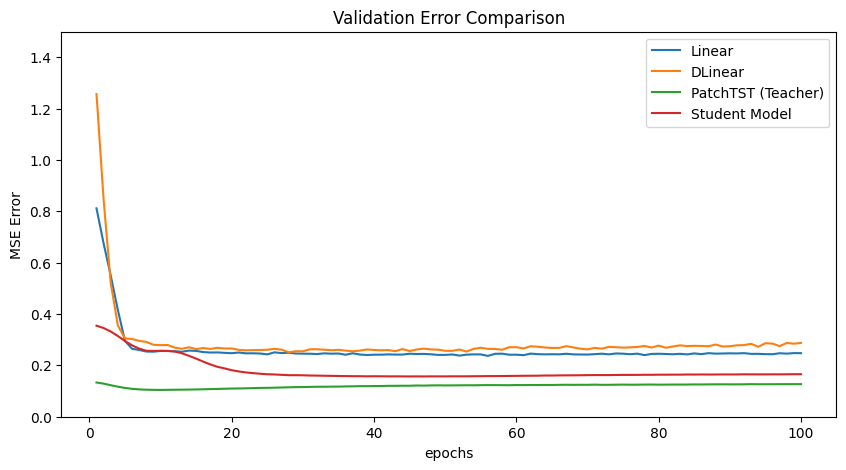

In [28]:
# === 수정: 결과 시각화 ===
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(1, Linear_learner.epochs+1), Linear_valid_history, label="Linear")
ax.plot(np.arange(1, DLinear_learner.epochs+1), DLinear_valid_history, label="DLinear")
ax.plot(np.arange(1, patchtst_learner.epochs+1), patchtst_valid_history, label="PatchTST (Teacher)")
ax.plot(np.arange(1, student_learner.epochs+1), student_valid_history, label="Student Model")  # 추가
ax.set_xlabel("epochs")
ax.set_ylabel("MSE Error")
ax.set_ylim(0, 1.5)
ax.legend()
plt.title("Validation Error Comparison")
plt.show()

In [29]:
teacher_params = count_parameters(patchtst_model)
student_params = count_parameters(student_model)

print(f"Teacher Model Parameters: {teacher_params}")
print(f"Student Model Parameters: {student_params}")
print(f"Compression Ratio: {teacher_params / student_params:.2f}x")

torch.save(patchtst_model.state_dict(), "teacher_model.pth")
torch.save(student_model.state_dict(), "student_model.pth")

import os
teacher_size = os.path.getsize("teacher_model.pth") / 1024  # KB
student_size = os.path.getsize("student_model.pth") / 1024  # KB

print(f"Teacher Model Size: {teacher_size:.2f} KB")
print(f"Student Model Size: {student_size:.2f} KB")

Teacher Model Parameters: 468800
Student Model Parameters: 104848
Compression Ratio: 4.47x
Teacher Model Size: 1861.20 KB
Student Model Size: 420.38 KB
